# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# Few Notes

1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


In [3]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)


sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [4]:
import pandas as pd
data = pd.read_csv('preprocessed_data.csv')

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [5]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
sid = SentimentIntensityAnalyzer()
temp = data['essay'].apply(sid.polarity_scores)
sentiment = []
for i in tqdm(range(len(temp))):
    sentiment.append([temp[i]['neg'],temp[i]['pos'],temp[i]['neu'],temp[i]['compound']])
senti = pd.DataFrame(sentiment,columns=["neg_sentiment","pos_sentiment","neu_sentiment","compound"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109248/109248 [00:01<00:00, 75440.75it/s]


In [6]:
data['neg_sentiment'] = senti['neg_sentiment']
data['pos_sentiment'] = senti['pos_sentiment']
data['neu_sentiment'] = senti['neu_sentiment']
data['compound'] = senti['compound']

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
y = data['project_is_approved']
X = data.drop(['project_is_approved'],axis = 1)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state=10,stratify=y)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
def vectorizer(df_train,df_test,name,vect):
    train = vect.fit_transform(df_train[name])
    test = vect.transform(df_test[name])
    return train,test,vect

tfidf_train,tfidf_test,tfid_vect = vectorizer(df_train=X_train,df_test=X_test,name='essay',vect = TfidfVectorizer())

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [12]:
import pickle

In [13]:
f = open('glove_vectors', 'rb')
model = pickle.load(f)
glove_words =  set(model.keys())

In [14]:
word_idf_map = dict(zip(tfid_vect.vocabulary_, list(tfid_vect.idf_)))

In [15]:
tf_idf_vocab = set(tfid_vect.vocabulary_.keys())

In [16]:
from nltk.probability import FreqDist
import numpy as np
from tqdm import tqdm

In [17]:
def sentToDoc(sentence):
    ''' Input a sentence and output would be its vector represntation '''
    word_feq = FreqDist(sentence)
    total_length = len(sentence.split(' '))
    sentVec = np.zeros(model['post'].shape)
    count = 0
    for word in sentence.split(' '):
        if (word in glove_words) and (word in tf_idf_vocab):
            tf_idf = (word_feq[word]/total_length)*word_idf_map[word]
            sentVec += model[word]*tf_idf# glove vector * tf * idf
            count += tf_idf
    if count == 0:
        return sentVec
    return sentVec/count

def tfid_glove(data):
    vectors = []
    for doc in tqdm(data):
        vectors.append(sentToDoc(doc))
    return np.array(vectors)
glove_train_vector = tfid_glove(X_train['essay'])
glove_test_vector = tfid_glove(X_test['essay'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27312/27312 [00:23<00:00, 1154.63it/s]


#### 5. perform encoding of categorical features.

# change this

In [18]:
class ResponseEncoder():
    
    def __init__(self):
        self.unique_class = None
        self.dim = None
        self.vectors = None
        self.eqvect = None
    
    def fit(self,X,y):# x with labels
        # Find unique values in x and y
        self.unique_class = y.unique()
        self.dim =len(self.unique_class)
        self.eqvect = np.ones(self.dim)/self.dim
        # Combine two series.
        df=pd.concat([X,y],axis=1)
        df.columns = ['data','label']
        self.vectors = dict()
        for cat, data in df.groupby('data'):
            #print(data)
            temp = data['label'].value_counts() # will return series
            total = len(data)
            vect = np.zeros(self.dim)
            count = 0
            for idx,i in enumerate(self.unique_class):
                if i in temp.index:
                    vect[idx] = temp[i]
                else:
                    vect[idx] = 0
            vect = vect/total
            self.vectors[str(cat)] = vect

    def transform(self,X):
        vectors = []     
        for cat in X:
            if self.vectors.get(str(cat)) is None:
                vectors.append(self.eqvect)
            else:
                vectors.append(self.vectors[str(cat)])
        return np.array(vectors)
    

In [19]:
def responseCoding(X_train,X_test,name,vect,y_train):
    vect.fit(X_train[name],y_train)
    train = vect.transform(X_train[name])
    test = vect.transform(X_test[name])
    return train,test,vect

In [20]:
train_state,test_state,model_state = responseCoding(X_train,X_test,'school_state',ResponseEncoder(),y_train)
train_prefix, test_prefix,model_prefix = responseCoding(X_train,X_test,'teacher_prefix',ResponseEncoder(),y_train)
train_grade, test_grade,model_grade = responseCoding(X_train,X_test,'project_grade_category',ResponseEncoder(),y_train)
trian_cat, test_cat,model_cat = responseCoding(X_train,X_test,'clean_categories',ResponseEncoder(),y_train)
train_sub, test_sub,model_sub = responseCoding(X_train,X_test,'clean_subcategories',ResponseEncoder(),y_train)

#### 6. perform encoding of numerical features

In [21]:
def vecotizer2d(df_train,df_test,name,vect):
    train = vect.fit_transform(df_train[name].values.reshape(-1,1))
    test = vect.transform(df_test[name].values.reshape(-1,1))
    return train , test, vect

In [22]:
from sklearn.preprocessing import StandardScaler
train_price,test_price,model_price = vecotizer2d(X_train,X_test,'price',StandardScaler())
train_prev_posted, test_prev_posted,model_prev_posted = vecotizer2d(X_train, X_test,'teacher_number_of_previously_posted_projects',StandardScaler())
train_neg_sentiment,test_neg_sentiment,model_neg_sentiment = vecotizer2d(X_train,X_test,'neg_sentiment',StandardScaler())
train_pos_sentiment,test_pos_sentiment,model_pos_sentiment = vecotizer2d(X_train,X_test,'pos_sentiment',StandardScaler())
train_neu_sentiment,test_neu_sentiment,model_neu_sentiment = vecotizer2d(X_train,X_test,'neu_sentiment',StandardScaler())
train_compound,test_compound,model_compound = vecotizer2d(X_train,X_test,'compound',StandardScaler())


In [23]:
train_set_common = np.hstack((train_state,train_prefix,train_grade,trian_cat,train_sub,train_price,train_prev_posted,
                           train_neg_sentiment,train_pos_sentiment,train_neu_sentiment,train_compound))
test_set_common = np.hstack((test_state,test_prefix,test_grade,test_cat,test_sub,test_price,test_prev_posted,
                          test_neg_sentiment,test_pos_sentiment,test_neu_sentiment,test_compound))


In [24]:
type(tfidf_train)

scipy.sparse._csr.csr_matrix

In [25]:
train_set_common.shape

(81936, 16)

In [26]:
from scipy.sparse import hstack

In [27]:
train_set_1 = hstack((tfidf_train,train_set_common))
test_set_1 = hstack((tfidf_test,test_set_common))

In [28]:
train_set_2 = np.hstack((glove_train_vector,train_set_common))
test_set_2 = np.hstack((glove_test_vector,test_set_common))

In [29]:
def saveFile(name,var):
    file = open(name,'wb')
    pickle.dump(var,file)
    file.close()
saveFile('train_set_1.pkl',train_set_1)
saveFile('train_set_2.pkl',train_set_2)
saveFile('test_set_1.pkl',test_set_1)
saveFile('test_set_2.pkl',test_set_2)
saveFile('label_train.pkl',y_train)
saveFile('label_test.pkl',y_test)

# Load Data

In [1]:
import pickle
def loadPickelb(name):
    file = open(name,'rb')
    return pickle.load(file)

train_set_1 = loadPickelb('train_set_1.pkl')
train_set_2 = loadPickelb('train_set_2.pkl')
test_set_1 = loadPickelb('test_set_1.pkl')
test_set_2 = loadPickelb('test_set_2.pkl')
y_train =    loadPickelb('label_train.pkl')
y_test =     loadPickelb('label_test.pkl')

<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

https://www.kaggle.com/code/tilii7/hyperparameter-grid-search-with-xgboost/notebook

#### SET 1

In [2]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [3]:
hp = {  'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [1, 2, 3]
        }

In [4]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, objective='binary:logistic',silent=True, nthread=7,tree_method='gpu_hist')

In [5]:
gs = GridSearchCV(xgb,param_grid=hp,scoring="roc_auc",n_jobs=5,cv=5,return_train_score=True)

In [6]:
gs.fit(train_set_1,y_train)

[23:28:11] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat...t=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=7,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None, ...),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'max_depth': [1, 2, 3]},
             return_train_score=True, scoring='roc_auc')

In [7]:
print("Optimal Hyperparameter is for dataset 1 : ",gs.best_params_)

Optimal Hyperparameter is for dataset 1 :  {'colsample_bytree': 1.0, 'max_depth': 3}


In [8]:
mean_test_score = gs.cv_results_['mean_test_score'].reshape(3,3)

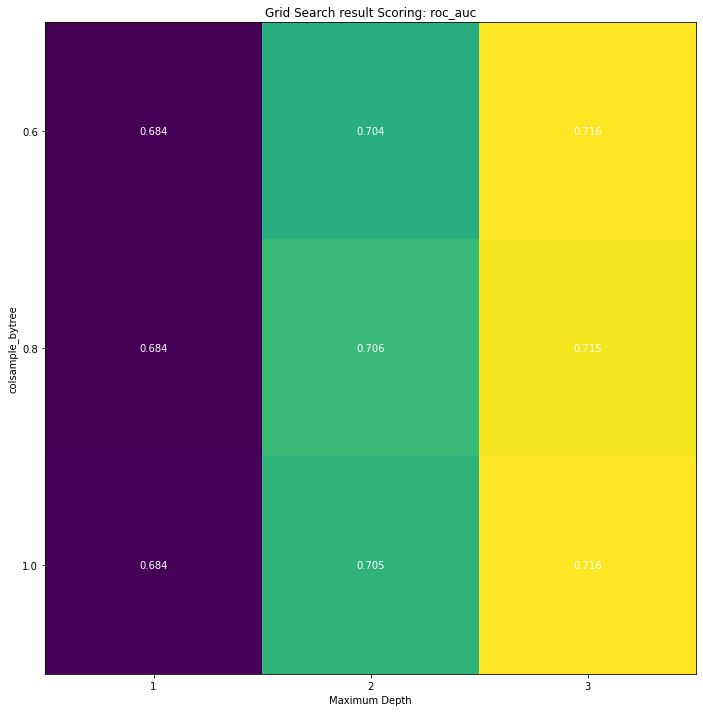

In [9]:
import matplotlib.pyplot as plt
def plotHeatmap(hp,mean_test_score):
    y_labels = hp['colsample_bytree']
    x_labels = hp['max_depth']
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(mean_test_score)
    ax.set_xticks(np.arange(len(x_labels)), labels=x_labels)
    ax.set_yticks(np.arange(len(y_labels)), labels=y_labels)

    # Loop over data dimensions and create text annotations.
    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            text = ax.text(j, i, round(mean_test_score[i, j],3),
                           ha="center", va="center", color="w")
    ax.set_xlabel("Maximum Depth")
    ax.set_ylabel("colsample_bytree")
    ax.set_title("Grid Search result Scoring: roc_auc")
    fig.tight_layout()
    plt.show()
plotHeatmap(hp,mean_test_score)

[23:28:37] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Optimal Hyperparameter is for dataset 1 :  {'colsample_bytree': 1.0, 'max_depth': 3}


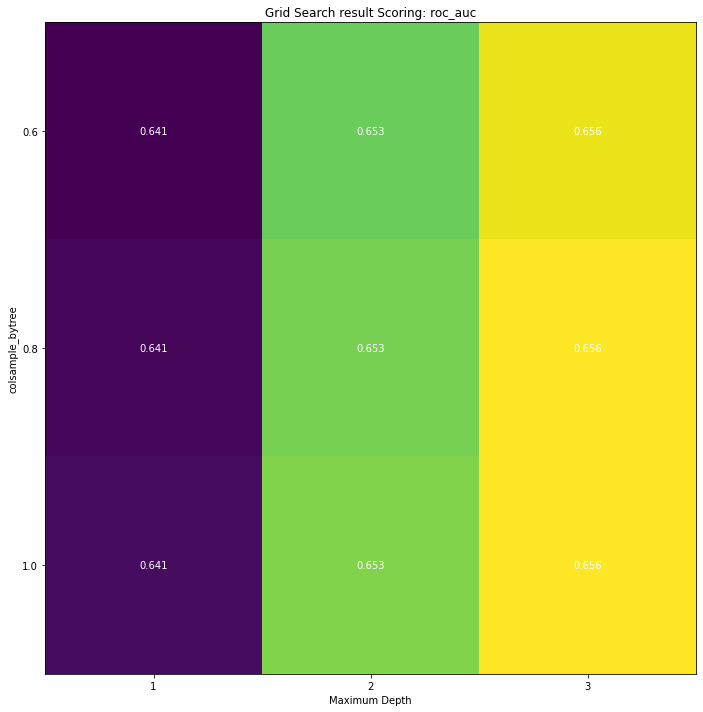

In [10]:
gs2 = GridSearchCV(xgb,param_grid=hp,scoring="roc_auc",n_jobs=5,cv=5,return_train_score=True)
gs2.fit(train_set_2,y_train)
print("Optimal Hyperparameter is for dataset 1 : ",gs.best_params_)
mean_test_score = gs2.cv_results_['mean_test_score'].reshape(3,3)
plotHeatmap(hp,mean_test_score)

In [13]:
best_xgb_1 = xgb = XGBClassifier(max_depth = 3,learning_rate=0.1, n_estimators=100, objective='binary:logistic',silent=True, nthread=7,tree_method='gpu_hist')
best_xgb_1.fit(train_set_1,y_train)

y_test_pred = best_xgb_1.predict_proba(test_set_1)
y_train_pred = best_xgb_1.predict_proba(train_set_1)

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

TRAIN AUC SCORE 0.7470887717929511
TEST AUC SCORE 0.7108040958547333


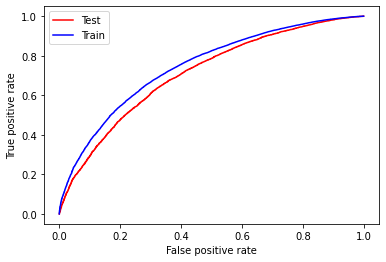

0.4326704240574572

In [15]:
def roc_curve_plot(y_train,y_test,y_train_prob,y_test_prob):
    train = roc_curve(y_train,y_train_prob[:,1])
    test  = roc_curve(y_test,y_test_prob[:,1])
    print("TRAIN AUC SCORE",roc_auc_score(y_train, y_train_prob[:,1]))
    print("TEST AUC SCORE",roc_auc_score(y_test, y_test_prob[:,1]))
    opt = [ (1-test[0][i])*(test[1][i]) for i in range(len(test[0]))]
    optimal_theta = opt[opt.index(max(opt))]
    plt.plot(test[0],test[1],label="Test",color='red')
    plt.plot(train[0],train[1],label="Train",color='blue')
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()
    plt.show()
    return optimal_theta
roc_curve_plot(y_train,y_test,y_train_pred,y_test_pred)

[23:40:49] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


TRAIN AUC SCORE 0.6740136391681725
TEST AUC SCORE 0.6440452447880329


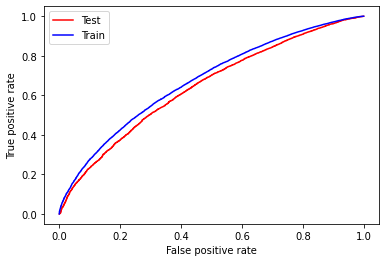

0.36495130607059

In [17]:
best_xgb_2 = xgb = XGBClassifier(max_depth = 3,learning_rate=0.1, n_estimators=100, objective='binary:logistic',silent=True, nthread=7,tree_method='gpu_hist')
best_xgb_2.fit(train_set_2,y_train)

y_test_pred_2 = best_xgb_2.predict_proba(test_set_2)
y_train_pred_2 = best_xgb_2.predict_proba(train_set_2)
roc_curve_plot(y_train,y_test,y_train_pred_2,y_test_pred_2)

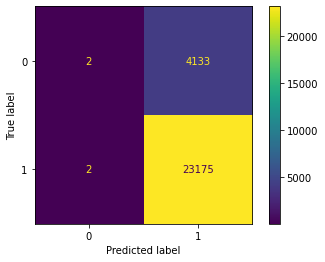

In [18]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
def confusionMatrix(optimal_theta,predicted,y_test):
    predicted[predicted>optimal_theta] = 1
    predicted[predicted<= optimal_theta] = 0
    matrix = confusion_matrix(y_test,predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()
    return predicted
predicted_set_1  =confusionMatrix(0.4326704240574572,y_test_pred[:,1],y_test)

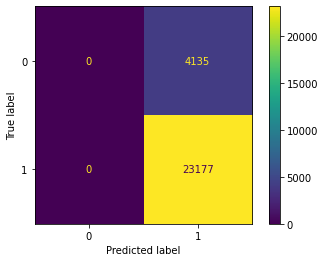

In [19]:
predicted_set_1  =confusionMatrix(0.36495130607059,y_test_pred_2[:,1],y_test)

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [20]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]
x.add_row(["Glove", "xgboost", ["max_depth: 3" , "colsample_bytree: 1"],0.6440 ])
x.add_row(["TFIDF","xgboost", ["max_depth: 3" , "colsample_bytree: 1"],0.7108 ])
print(x)

+------------+---------+-----------------------------------------+--------+
| Vectorizer |  Model  |             Hyper Parameter             |  AUC   |
+------------+---------+-----------------------------------------+--------+
|   Glove    | xgboost | ['max_depth: 3', 'colsample_bytree: 1'] | 0.644  |
|   TFIDF    | xgboost | ['max_depth: 3', 'colsample_bytree: 1'] | 0.7108 |
+------------+---------+-----------------------------------------+--------+
